# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [49]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from time import gmtime,strftime
from scipy.stats import linregress
import os

# Import API key
from config import weather_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output Date (for csv and images)
output_date = strftime("%m%d%Y",gmtime())
output_path = "output/%s/" % output_date

# API variables
query_url = "http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=%s&q=" % weather_key

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Plot Generator Functions

In [30]:
def buildLatPlot(y, ylabel, df, grid=False, title_prefix = "", linregress=False, save=False):
    x_val = df["Lat"]
    y_val = df[y]
    
    # X limits
    x_min = x_val.min()
    x_max = x_val.max()
    x_lim = getLimits(x_min, x_max, 10)
    
    # Y limits
    y_min = y_val.min()
    y_max = y_val.max()
    y_lim = getLimits(y_min, y_max, 5)
    
    # Create title
    date = strftime("%m/%d/%Y",gmtime())
    title = "{0}City Latitude vs. {1}: {2}".format(title_prefix,ylabel,date)
    
    # Create and show plot
    lat_plt = df.plot(kind="scatter", x="Lat", y=y, grid=grid,
                       edgecolor="black", facecolor="blue", alpha=.75,
                       xlim=x_lim, ylim=y_lim, title=title)
    xlabel = "Latitude"
    lat_plt.set_xlabel(xlabel)
    lat_plt.set_ylabel(ylabel)
    lat_plt.axvline(0, color='black', linestyle='-', linewidth='3')
    
    # If desired, add the linear regression line and equation to the plot
    if linregress is True:
        x = {
            "values": x_val,
            "min": x_min,
            "max": x_max
        }
        y = {
            "values": y_val,
            "min": y_min,
            "max": y_max
        }
        addLinregress(x,y,lat_plt)
    
    # If desired, save the plot as a png in the output folder
    if save is True:
        output_ylabel = " ".join(ylabel.split()[:-1])
        #check if today already has a directory
        if os.path.isdir(output_path) is False:
            createNewDir(output_path)
        lat_plt.figure.savefig("{0}{1}{2}-{3}.png".format(output_path,title_prefix,xlabel,output_ylabel))

In [3]:
# Gets the limits of the chart based on the minimum and maximum values
# The landmark value is what to round to so no plot points are chopped off when the plot renders
def getLimits(in_min, in_max, landmark):
    # get minimum
    if in_min <= 0:
        out_min = in_min-(landmark-(abs(in_min)%landmark))
    else:
        out_min = in_min-(in_min%landmark)
    # get maximum
    if in_max >= 0:
        out_max = in_max+(landmark-(in_max%landmark))
    else:
        out_max = in_max+(abs(in_max)%landmark)
    return (out_min,out_max)

In [4]:
# Add linear regression line and equation to the plot
def addLinregress(x,y,lat_plt):
    # get linear regression values and plot the line
    slope, intercept, rvalue, pvalue, stderr = linregress(x["values"], y["values"])
    lin_val = slope*x["values"] + intercept
    lat_plt.plot(x["values"],lin_val,"-",color="red")
    
    # create the equation string
    lin_eq = "y = {0}x + {1}".format(round(slope,2),round(intercept,2))
    
    # create coordinates for linear regression equation based on slope to try and minimize collision the data
    lin_x_buffer = (abs(.05*(x["min"]+x["max"])))
    lin_x = x["min"]+lin_x_buffer
    
    lin_y_buffer = (abs(.1*(y["min"]+y["max"])))
    if slope > -1:
        lin_y = y["max"]-lin_y_buffer
    else:
        lin_y = y["min"]+lin_y_buffer
    
    # add to existing plot
    lat_plt.annotate(lin_eq,(lin_x, lin_y),fontsize=15,color="red")
    
    # print r value
    print(f"The r-value is: {rvalue}")

In [5]:
# Create a date-specific folder
def createNewDir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Failed to create directory for %s. Saving to output/" % path)
        output_path = "output/"
    else:
        print ("Created directory for %s" % path)

## Generate Cities List

In [6]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

602

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [7]:
# Print title and divider
print_title = "Beginning Data Retrieval"
print(print_title)
print(len(print_title)*"-")

# Request weather data from every city in list
# Instantiate counters and city list
record = 1
rec_set = 1
city_list = []

# Loop through the cities and store the api response
for city in cities:
    response = requests.get(query_url + city).json()
    # if the response doesn't have a name, skip adding it to the city list and do not increment
    try:
        print(f"Processing Record {record} of Set {rec_set} | {response['name']}")
    except KeyError:
        print("City not found. Skipping...")
    else:
        city_list.append(response)
        if record == 50:
            record = 1
            rec_set += 1
        else:
            record += 1
    # Lastly, wait a second before making another call
    finally:
        time.sleep(1)

Beginning Data Retrieval
------------------------
City not found. Skipping...
Processing Record 1 of Set 1 | Sungai Penuh
City not found. Skipping...
Processing Record 2 of Set 1 | Rome
Processing Record 3 of Set 1 | Cairns
Processing Record 4 of Set 1 | Kapaa
Processing Record 5 of Set 1 | Rikitea
Processing Record 6 of Set 1 | Chokurdakh
Processing Record 7 of Set 1 | Ambilobe
Processing Record 8 of Set 1 | Murray Bridge
Processing Record 9 of Set 1 | Mataura
Processing Record 10 of Set 1 | Pochutla
Processing Record 11 of Set 1 | Lebu
Processing Record 12 of Set 1 | Avarua
Processing Record 13 of Set 1 | Palamós
Processing Record 14 of Set 1 | Butaritari
Processing Record 15 of Set 1 | Pevek
Processing Record 16 of Set 1 | Vaini
Processing Record 17 of Set 1 | Deputatsky
Processing Record 18 of Set 1 | Longyearbyen
Processing Record 19 of Set 1 | Qaanaaq
Processing Record 20 of Set 1 | Port Elizabeth
Processing Record 21 of Set 1 | Castro
Processing Record 22 of Set 1 | Hilo
Process

Processing Record 34 of Set 4 | Tanout
Processing Record 35 of Set 4 | Kabanjahe
City not found. Skipping...
Processing Record 36 of Set 4 | Abu Samrah
Processing Record 37 of Set 4 | Vardø
Processing Record 38 of Set 4 | Tagusao
Processing Record 39 of Set 4 | Burnie
Processing Record 40 of Set 4 | Saint-Pierre
City not found. Skipping...
Processing Record 41 of Set 4 | Kumluca
Processing Record 42 of Set 4 | Homer
Processing Record 43 of Set 4 | Kudat
Processing Record 44 of Set 4 | Atar
Processing Record 45 of Set 4 | Gamboma
Processing Record 46 of Set 4 | Fort Saint James
Processing Record 47 of Set 4 | Acapulco de Juárez
City not found. Skipping...
City not found. Skipping...
Processing Record 48 of Set 4 | Laas
Processing Record 49 of Set 4 | Esperance
Processing Record 50 of Set 4 | Shirhatti
City not found. Skipping...
Processing Record 1 of Set 5 | Nouadhibou
Processing Record 2 of Set 5 | Calamar
Processing Record 3 of Set 5 | Channel-Port aux Basques
Processing Record 4 of 

City not found. Skipping...
Processing Record 17 of Set 8 | Vestmanna
Processing Record 18 of Set 8 | Tignère
Processing Record 19 of Set 8 | Gainesville
Processing Record 20 of Set 8 | Passa Quatro
Processing Record 21 of Set 8 | Belmonte
Processing Record 22 of Set 8 | Ulety
Processing Record 23 of Set 8 | Matara
City not found. Skipping...
Processing Record 24 of Set 8 | Port Hawkesbury
Processing Record 25 of Set 8 | Kysyl-Syr
Processing Record 26 of Set 8 | Ambulu
City not found. Skipping...
Processing Record 27 of Set 8 | Bilibino
Processing Record 28 of Set 8 | Warrnambool
Processing Record 29 of Set 8 | Nauta
Processing Record 30 of Set 8 | Ixtapa
Processing Record 31 of Set 8 | Ust'-Kut
City not found. Skipping...
Processing Record 32 of Set 8 | Aksarka
Processing Record 33 of Set 8 | Chopinzinho
Processing Record 34 of Set 8 | Salamiyah
Processing Record 35 of Set 8 | Maniitsoq
Processing Record 36 of Set 8 | Simao
Processing Record 37 of Set 8 | Barra do Garças
Processing Re

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [50]:
# Create empty dictionary to add api data to
cities_df = {}

# Add City, Lat, Long, Max Temp, Humidity, Cloudiness, Wind Speed, Country, and Date
# Create empty lists for each soon-to-be column
cities_df["City"], cities_df["Lat"], cities_df["Lng"], cities_df["Max Temp"], cities_df["Humidity"], cities_df["Cloudiness"], cities_df["Wind Speed"], cities_df["Country"], cities_df["Date"] = ([] for x in range(9))
for i in range(len(city_list)):
    cities_df["City"].append(city_list[i]["name"])
    cities_df["Lat"].append(city_list[i]["coord"]["lat"])
    cities_df["Lng"].append(city_list[i]["coord"]["lon"])
    cities_df["Max Temp"].append(city_list[i]["main"]["temp_max"])
    cities_df["Humidity"].append(city_list[i]["main"]["humidity"])
    cities_df["Cloudiness"].append(city_list[i]["clouds"]["all"])
    cities_df["Wind Speed"].append(city_list[i]["wind"]["speed"])
    cities_df["Country"].append(city_list[i]["sys"]["country"])
    cities_df["Date"].append(city_list[i]["dt"])
cities_df = pd.DataFrame(cities_df)
if os.path.isdir(output_path) is False:
    createNewDir(output_path)
cities_df.to_csv("%scities.csv" % output_path, index=False)
cities_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Sungai Penuh,-2.08,101.38,67.80,90,91,3.24,ID,1609773157
1,Rome,43.21,-75.46,33.80,86,90,1.83,US,1609773102
2,Cairns,-16.92,145.77,78.80,94,75,3.36,AU,1609773033
3,Kapaa,22.08,-159.32,73.40,78,75,10.29,US,1609773161
4,Rikitea,-23.12,-134.97,77.14,81,17,15.55,PF,1609773162


In [9]:
cities_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,5.460000e+02
mean,19.543974,16.134322,51.171245,74.732601,57.454212,8.535495,1.609773e+09
std,34.292894,91.882241,33.626850,18.698229,38.302546,5.860271,2.057868e+02
min,-54.800000,-179.170000,-49.650000,10.000000,0.000000,0.580000,1.609773e+09
25%,-8.815000,-62.067500,32.000000,65.250000,20.000000,4.540000,1.609773e+09
50%,22.300000,19.100000,60.800000,79.000000,75.000000,6.930000,1.609773e+09
75%,48.977500,100.560000,78.800000,87.750000,91.000000,11.410000,1.609774e+09
max,78.220000,179.320000,100.330000,100.000000,100.000000,36.910000,1.609774e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [10]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
clean_city_df = cities_df.loc[cities_df["Humidity"] <= 100, :]
clean_city_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Sungai Penuh,-2.08,101.38,67.80,90,91,3.24,ID,1609773157
1,Rome,43.21,-75.46,33.80,86,90,1.83,US,1609773102
2,Cairns,-16.92,145.77,78.80,94,75,3.36,AU,1609773033
3,Kapaa,22.08,-159.32,73.40,78,75,10.29,US,1609773161
4,Rikitea,-23.12,-134.97,77.14,81,17,15.55,PF,1609773162


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

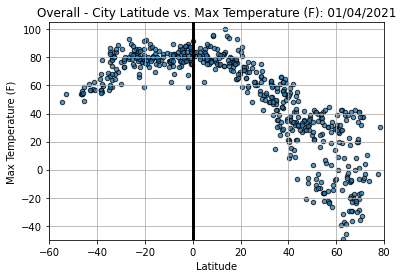

In [31]:
buildLatPlot("Max Temp", "Max Temperature (F)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's maximum temperature and its latitude. Overall, the points are relatively tightly clustered with about 20 degrees Fahrenheit of separation between all cities at a specific latitude. This holds true from -60 degrees to about 25 degrees latitude where the variance begins to increase. The trend still holds true -- the closer to the equator, the greater the maximum temperature -- but above 25 degrees latitude, the correlation weakens slightly.

## Latitude vs. Humidity Plot

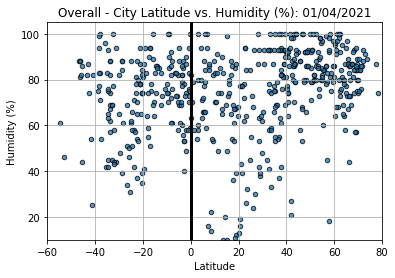

In [32]:
buildLatPlot("Humidity", "Humidity (%)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's humidity percentage and its latitude. Since the points are relatively spread out with a slightly more concentrated portion in the 50-70 degrees latitude and 70-90% humidity. This visual bunching may also just be a product of more cities getting included in that latitude. Overall, the correlation is very weak suggesting that latitude may not play a major role in a city's humidity. Further year-round testing would be needed to strengthen/debunk this observation.

## Latitude vs. Cloudiness Plot

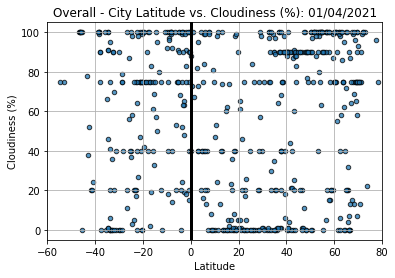

In [33]:
buildLatPlot("Cloudiness", "Cloudiness (%)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's cloudiness percentage and its latitude. As with humidity, more year-round data would be needed to develop an understanding as to whether latitude plays a role in cloudiness.

## Latitude vs. Wind Speed Plot

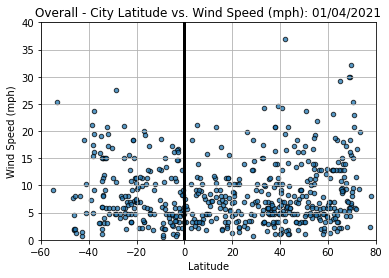

In [34]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's wind speed and its latitude. Generally, the wind speed does not seem to be impacted by the latitude -- again, more year-round data would help with this claim. However, it is interesting to point out that the clear outliers (> 25mph) all exist outside of the tropics. May be a coincidence of the data pulled today, but might be something to look for in the future.

## Linear Regression

In [35]:
# Collect hemisphere-specific data
# Both include cities on the Equator
north_hemi_df = clean_city_df.loc[clean_city_df["Lat"] >= 0, :]
south_hemi_df = clean_city_df.loc[clean_city_df["Lat"] <= 0, :]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.8401698416200369


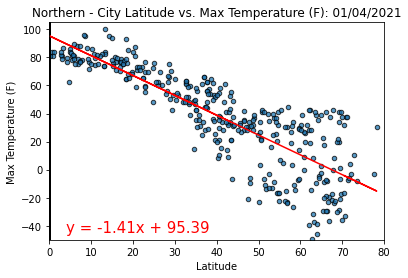

In [41]:
buildLatPlot("Max Temp", "Max Temperature (F)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.594686982935872


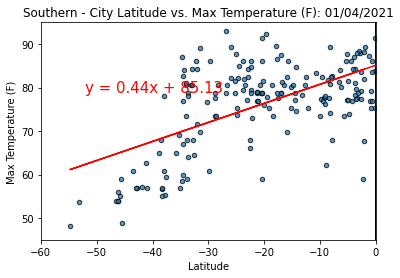

In [42]:
buildLatPlot("Max Temp", "Max Temperature (F)", south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.33048525311849003


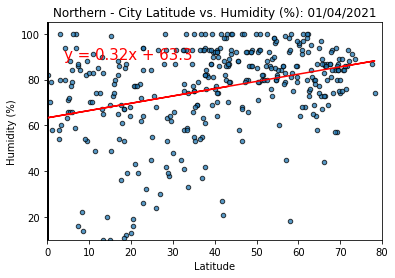

In [43]:
buildLatPlot("Humidity", "Humidity (%)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.11416017590785925


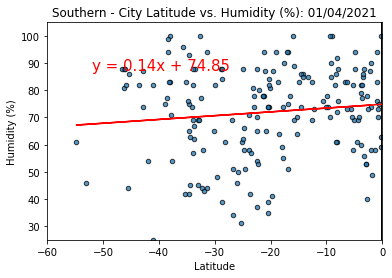

In [44]:
buildLatPlot("Humidity", "Humidity (%)",south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.2682963283696059


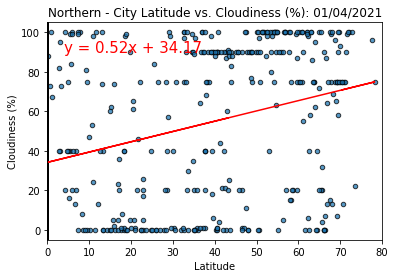

In [45]:
buildLatPlot("Cloudiness", "Cloudiness (%)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.13332140054926364


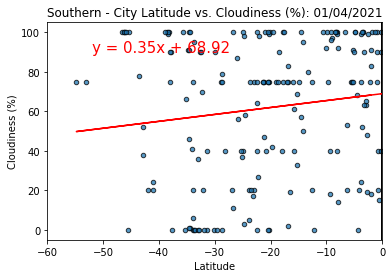

In [46]:
buildLatPlot("Cloudiness", "Cloudiness (%)", south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.1919008496080922


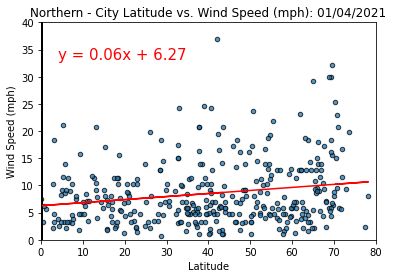

In [47]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.17057095991155705


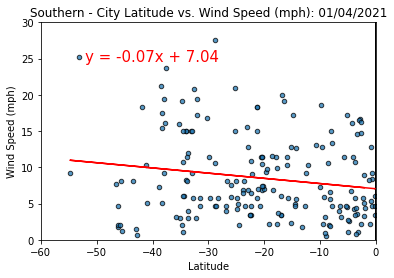

In [48]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)